In [1]:
from lib.hamiltonian import H_B, H_D, H_P
from lib.time import S
from lib import X, D
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from joblib import Memory
import itertools

memory = Memory(location=".joblib_cache", verbose=0)

N = 2
nsteps = 2000
T_0 = 0.05
T_f = 3
# Setup the psi_gs
Hf_gs = H_B(N) + T_f * H_P(N) 
E, V = np.linalg.eigh(Hf_gs)
beta = 1
psi_gs = V[:, np.argmin(E)]
ts = np.linspace(T_0, T_f, nsteps)
f_all = False

After we have imported all of our dependencies, we can go ahead and implement the Time-dependent Schrodinger equation which was proposed by Yves Rezus.



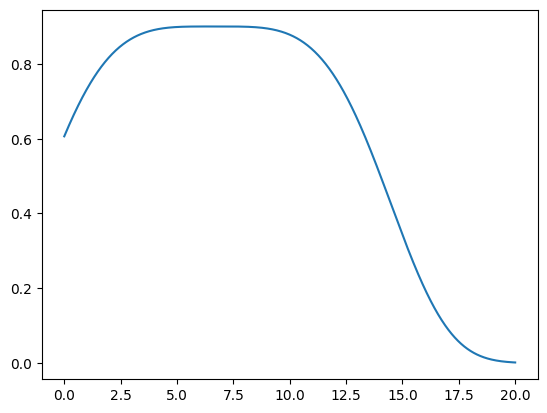

In [2]:
x = np.linspace(0, D, 1000)

y = S(x)

plt.plot(x, y)
plt.show()

To first understand how the energies change in this new scheme we should look at how the hamiltonian changes as we tune $ \gamma $ from 0 -> 1. 

$$
 H = \gamma*H_f + (1 - \gamma)*H_i
$$

In [3]:
def hamiltonian_energies(N):
    energies = []
    gamma_vals = []
    vecs = []
    
    Hi = beta * H_D(N, X)
    Hf = H_B(N) + T_f * H_P(N)
    for t in ts:
        gamma = t/T_f
        H = gamma * Hf + (1 - gamma) * Hi
        eigvals, vec = np.linalg.eigh(H)
        energies.append(eigvals)
        vecs.append(vec)
        gamma_vals.append(gamma)

    return np.array(energies), np.array(vecs), gamma_vals

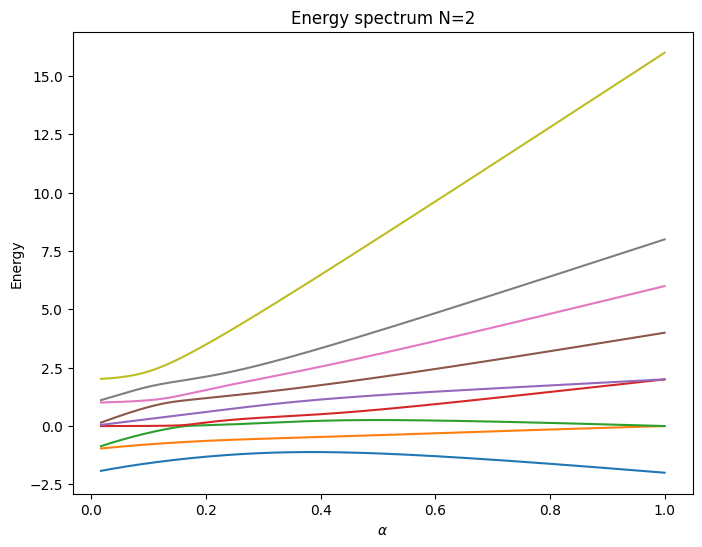

In [4]:
energies, vecs, gamma_vals = hamiltonian_energies(N)

plt.figure(figsize=(8, 6))
for i in range(energies.shape[1]):
    plt.plot(gamma_vals, energies[:, i])
plt.xlabel(r"$\alpha$")
plt.ylabel("Energy")
plt.title(f"Energy spectrum {N=}")
plt.show()

We can no see how the energy spectrum looks 

(1, -1)


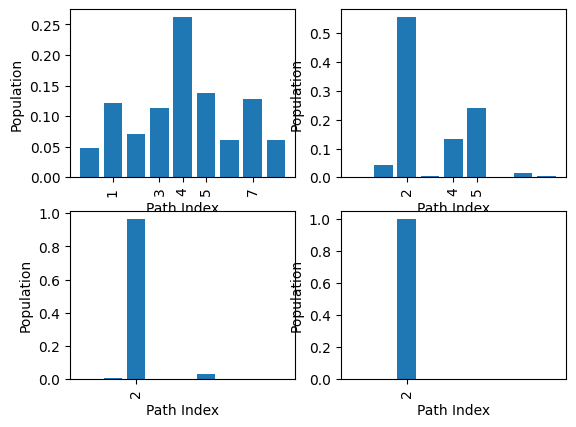

In [5]:
@memory.cache
def all_move_sequences(N):
    moves = (1, 0, -1)
    return list(itertools.product(moves, repeat=N))

vec = np.array([np.abs(v[:, 0])**2 for v in vecs])
fig, axes = plt.subplots(2, 2)
indices = np.arange(vecs.shape[1])
alpha_indices = np.linspace(0, len(vec)-1, 4, dtype=int)
selected_eigvecs = [vec[i] for i in alpha_indices]
moves = all_move_sequences(N)
for i, eigvec in enumerate(selected_eigvecs):
    ax = axes.flat[i]
    ax.bar(indices, eigvec, linewidth=1)
    ax_ids = []
    for j in range(len(eigvec)):
        if eigvec[j] > 0.1:
            ax_ids.append(j)
    ax.set_xlabel("Path Index")
    ax.set_ylabel("Population")
    ax.set_xticks(ax_ids)
    ax.set_xticklabels(ax_ids, rotation=90)
last = selected_eigvecs[-1]
ind = np.argwhere(last > 1e-2)
for i in ind:
    print(moves[i[0]])

In the plot above we can see which state we should end up in. 

In [13]:
@memory.cache
def yves_TDSE(Hi, Hf, T, steps=2000):
    dt = T / steps
    psi = 1/np.sqrt(3**N)*np.ones(3**N, dtype='complex')
    eA = sp.linalg.expm(-1j * Hf * dt**2 / 4.0)
    MA = sp.linalg.expm(-1j * Hf * dt**2 / 2.0)
    eB = sp.linalg.expm(-1j * Hi * dt + 1j * Hi * dt**2 / 2.0)
    MB = sp.linalg.expm(1j * Hi * dt**2)

    # Time-stepping using n index (clear and robust)
    for n in range(steps-1):
        # Strang step using current eA, eB
        psi = eA @ eB @ eA @ psi

        # update eA and eB for next step using the recursion
        eA = MA @ eA
        eB = MB @ eB

    # final normalization & sanity
    psi /= np.linalg.norm(psi)
    return psi



In [16]:

fidelities = []

gs_idx = np.argmax(psi_gs)
gammas = np.linspace(0.05, 1, 600)
print(gammas[0])
for t in ts:
    Hi_base = beta * H_D(N, X)
    Hf_base = H_B(N) + t * H_P(N)
    for gam in gammas:
        Hi = (1 - gam) * Hi_base
        Hf = gam * Hf_base 
        psi = yves_TDSE(Hi, Hf, t)
        
    if f_all:
        probability = np.abs(psi)**2
        fidelity = probability
    else:
        fidelity = np.abs(psi[gs_idx])**2
    fidelities.append(fidelity)

plt.figure()
# plt.ylim(0, 1)
plt.xlabel("Tf")
plt.ylabel(r"$ |<\psi^\dagger_{gs} | \psi(t=T_f)>|^2 $")
plt.plot(ts, fidelities)
search_point = 0.8

if not f_all:
    for yval in fidelities:
        if search_point +0.1 > yval > search_point - 0.1:
            index = fidelities.index(yval)
            xval = ts[index]
            # plt.plot(gammas[index], f, 'ro')
            plt.axhline(y=yval,  color='r', linestyle='--', label='Ideal Fidelity')
            plt.axvline(x=xval,  color='r', linestyle='--', label='Ideal Fidelity')
    
            # annotate the point
            plt.annotate(f'({xval:.3f}, {yval:.3f})',
                 xy=(xval, yval),
                 xytext=(xval + 0.05, yval - 0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    
            break
plt.show()

0.05


KeyboardInterrupt: 

In [ ]:
his = []
hfs = []
Hi_base = beta * H_D(N, X)
Hf_base = H_B(N) + t * H_P(N)
for gam in gammas:
    his.append(np.linalg.norm((1 - gam) * Hi_base))
    hfs.append(np.linalg.norm(gam * Hf_base))

plt.plot(gammas, his)
plt.plot(gammas, hfs)
plt.show()